#  Target Variable Creation

Bu notebook'ta popülarite skorunu ve target değişkenini oluşturacağız.

In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükle
df = pd.read_parquet("eda_data.parquet")

print(f" Veri yüklendi: {df.shape[0]:,} oyun, {df.shape[1]} özellik")

 Veri yüklendi: 63,389 oyun, 47 özellik


## 1. Veri Kontrolü

Yorumsuz oyunları kontrol edelim.

In [77]:
# Yorum kontrolü
both_zero = ((df['Positive'] == 0) & (df['Negative'] == 0)).sum()
has_reviews = ((df['Positive'] > 0) | (df['Negative'] > 0)).sum()

if both_zero > 0:
    df = df[(df['Positive'] > 0) | (df['Negative'] > 0)].copy()
    print(f"Temizlendi! Kalan oyun sayısı: {len(df):,}")
else:
    print(f"Tüm oyunların en az 1 yorumu var ({has_reviews:,} oyun)")

Tüm oyunların en az 1 yorumu var (63,389 oyun)


In [78]:
import numpy as np

# Achievements metinsel dağılım özeti
series = df['Achievements'].dropna()

bins = 10  # gerekirse değiştirilebilir
counts, edges = np.histogram(series, bins=bins)
total = int(counts.sum())

print(f"Toplam oyun: {total}")
print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):
    left = int(edges[i])
    # Son aralığı sağ ucu kapsayacak şekilde yazalım
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    pct = (cnt/total)*100 if total > 0 else 0
    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")

Toplam oyun: 63389
Aralık -> Adet (Yüzde) | Çubuk
[0 - 981] ->  63221 ( 99.7%) █████████████████████████████████████████████████
[982 - 1,963] ->     47 (  0.1%) █
[1,964 - 2,945] ->     25 (  0.0%) █
[2,946 - 3,927] ->     12 (  0.0%) █
[3,928 - 4,909] ->     13 (  0.0%) █
[4,910 - 5,891] ->     70 (  0.1%) █
[5,892 - 6,873] ->      0 (  0.0%) 
[6,874 - 7,855] ->      0 (  0.0%) 
[7,856 - 8,837] ->      0 (  0.0%) 
[8,838 - 9,821] ->      1 (  0.0%) █


Achievements üst sınır: 981
Silinen satır: 168 / Yeni satır sayısı: 63,221
Kalan oran: 99.73%


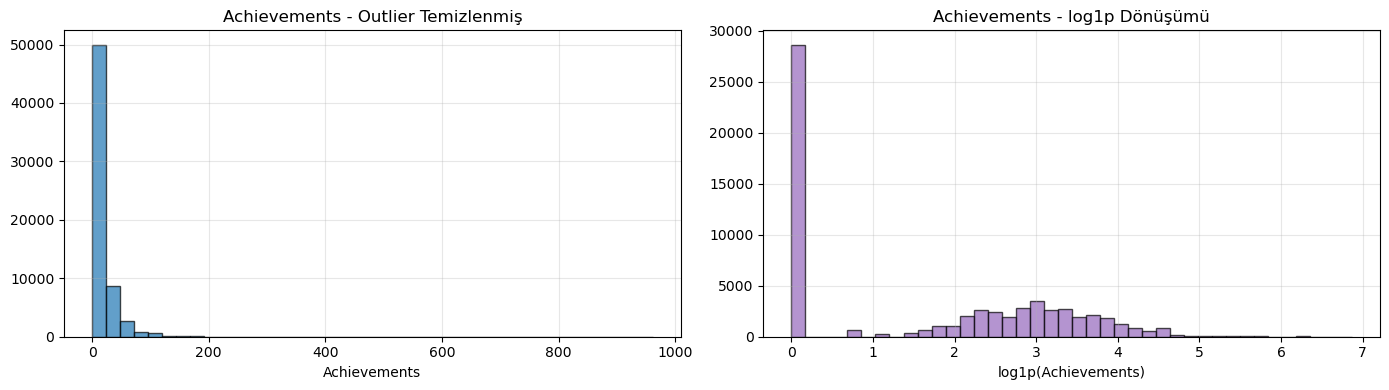

Çarpıklık (skewness):
  Orijinal: 10.20
  log1p    : 0.23


In [79]:
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt

# Outlier temizliği
upper_ach = 981
before_rows = len(df)
df = df[df['Achievements'] <= upper_ach].copy()
removed_rows = before_rows - len(df)

print(f"Achievements üst sınır: {upper_ach}")
print(f"Silinen satır: {removed_rows:,} / Yeni satır sayısı: {len(df):,}")
print(f"Kalan oran: {(len(df)/before_rows)*100:.2f}%")

# Log dönüşümü
orig_ach = df['Achievements']
log_ach = np.log1p(orig_ach)
df['log_achievements'] = log_ach

# Histogram karşılaştırması
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].hist(orig_ach, bins=40, edgecolor='black', alpha=0.7)
axes[0].set_title('Achievements - Outlier Temizlenmiş')
axes[0].set_xlabel('Achievements')
axes[0].grid(alpha=0.3)

axes[1].hist(log_ach, bins=40, edgecolor='black', alpha=0.7, color='tab:purple')
axes[1].set_title('Achievements - log1p Dönüşümü')
axes[1].set_xlabel('log1p(Achievements)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Çarpıklık (skewness):')
print(f'  Orijinal: {skew(orig_ach):.2f}')
print(f'  log1p    : {skew(log_ach):.2f}')


In [80]:
import numpy as np

# Achievements metinsel dağılım özeti
series = df['Achievements'].dropna()

bins = 10  # gerekirse değiştirilebilir
counts, edges = np.histogram(series, bins=bins)
total = int(counts.sum())

print(f"Toplam oyun: {total}")
print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):
    left = int(edges[i])
    # Son aralığı sağ ucu kapsayacak şekilde yazalım
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    pct = (cnt/total)*100 if total > 0 else 0
    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")

Toplam oyun: 63221
Aralık -> Adet (Yüzde) | Çubuk
[0 - 95] ->  62083 ( 98.2%) █████████████████████████████████████████████████
[96 - 191] ->    939 (  1.5%) █
[192 - 287] ->     76 (  0.1%) █
[288 - 383] ->     49 (  0.1%) █
[384 - 479] ->     16 (  0.0%) █
[480 - 575] ->     25 (  0.0%) █
[576 - 671] ->     14 (  0.0%) █
[672 - 767] ->      8 (  0.0%) █
[768 - 863] ->      8 (  0.0%) █
[864 - 961] ->      3 (  0.0%) █


In [81]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Varsayım: 'veri' adlı bir DataFrame'iniz var ve içinde 'achievements' ve 
# bağımsız değişken olarak kullanacağınız 'oynanan_saat' sütunu var.
veri = pd.DataFrame({
    'achievements': orig_ach, # Sizin Achievements veriniz
    'oynanan_saat': np.random.randint(1, 100, size=len(orig_ach)) # Örnek X değişkeni
})

# --- POISSON REGRESYONU ---
poisson_model = smf.poisson(
    'achievements ~ oynanan_saat', # Y ~ X
    data=veri
).fit(method="bfgs") # bfgs: optimizasyon metodu

print("POISSON MODEL ÖZETİ")
print(poisson_model.summary())


# --- NEGATİF BİNOM REGRESYONU (Daha iyi sonuç verme ihtimali yüksek) ---
negbin_model = smf.neg_binom(
    'achievements ~ oynanan_saat', # Y ~ X
    data=veri,
    # Negatif Binom parametresi (alpha) varyansı modellediği için genelde daha iyi uyum sağlar.
    log_alpha=1 # log(alpha) için başlangıç değeri
).fit(method="bfgs", maxiter=100)

print("\nNEGATİF BİNOM MODEL ÖZETİ")
print(negbin_model.summary())

ModuleNotFoundError: No module named 'statsmodels'

## Achievements Outlier Temizliği (İkinci Deneme - Kümülatif Yöntem)
İlk denemede yalnızca ilk bin üst sınırına (≈981) kadar tutuldu ve kuyruktaki tüm bilgiler kayboldu. Histogram dökümüne göre altı binin (0-5891 aralığı) sonunda kümülatif oran ≈%99.95 civarına ulaşıyor; bu noktadan sonraki değerler (çok seyrek tekil yüksekler) aşırı uç kabul edilebilir.

Bu adımda:
- Orijinal veri yeniden yüklenir (ilk agresif filtre öncesi duruma dönmek için).
- Pozitif/negatif yorumu olmayan oyunlar yine çıkarılır.
- 10 binlik histogram hesaplanır; kümülatif yüzdeler izlenir.
- Kümülatif yüzde > 99.95 eşiğini ilk geçen binin SOLUNDAN (önceki binin üst kenarı) eşik seçilir. Mevcut dağılımda bu eşik ≈ 5,891.
- Yeni eşik ile filtre uygulanır; hem eski (981) hem yeni (5,891) yöntem karşılaştırmalı raporlanır.

Amaç: Kuyruğun aşırı uç kısmını (çok az gözlem) atarken orta-yüksek Achievements bilgisini korumak.
Seçilen eşik: üst_bin_edge where cumulative <= 99.95 → 5,891.


== Kümülatif Histogram Özeti ==
[0 - 981] ->  63221 (99.73%) | Kümülatif:  99.73%
[982 - 1,963] ->     47 ( 0.07%) | Kümülatif:  99.81%
[1,964 - 2,945] ->     25 ( 0.04%) | Kümülatif:  99.85%
[2,946 - 3,927] ->     12 ( 0.02%) | Kümülatif:  99.87%
[3,928 - 4,909] ->     13 ( 0.02%) | Kümülatif:  99.89%
[4,910 - 5,891] ->     70 ( 0.11%) | Kümülatif: 100.00%
[5,892 - 6,873] ->      0 ( 0.00%) | Kümülatif: 100.00%
[6,874 - 7,855] ->      0 ( 0.00%) | Kümülatif: 100.00%
[7,856 - 8,837] ->      0 ( 0.00%) | Kümülatif: 100.00%
[8,838 - 9,821] ->      1 ( 0.00%) | Kümülatif: 100.00%

Seçilen yeni eşik (kümülatif ~%99.95): 4910
Eski agresif eşik: 982

Karşılaştırma:
  Agresif (<=   982)   kalan:  63221 /  99.73%  kaldırılan: 168
  Refined (<=  4910) kalan:  63318 /  99.89%  kaldırılan: 71

Skew orijinal: 23.45
Skew refined : 29.93


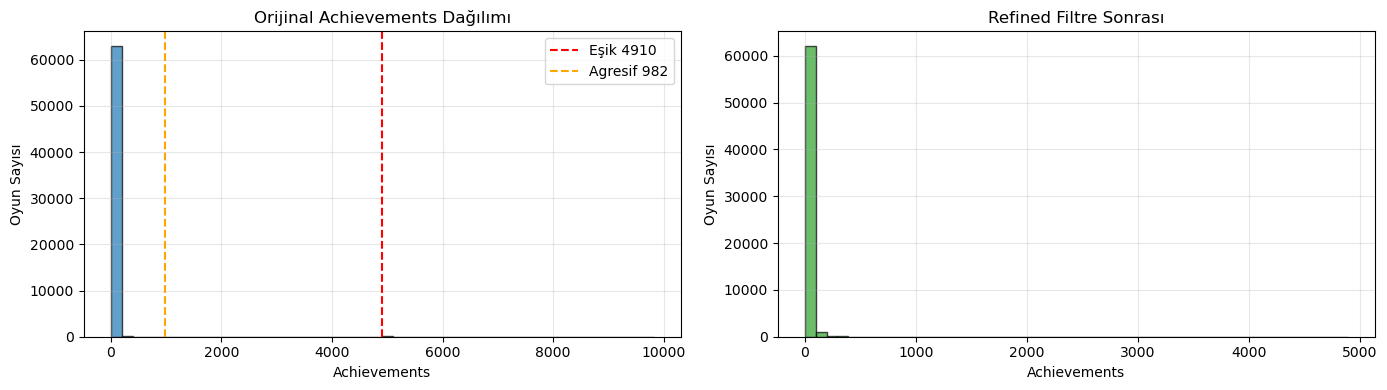

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

# Orijinal veriyi yeniden yükle (ilk agresif filtre öncesi duruma dönmek için)
orig_df = pd.read_parquet('eda_data.parquet')
orig_df = orig_df[(orig_df['Positive'] > 0) | (orig_df['Negative'] > 0)].copy()

ach = orig_df['Achievements'].dropna()

# Histogram (10 bin) ve kümülatif yüzde
bins = 10
counts, edges = np.histogram(ach, bins=bins)
percents = counts / counts.sum() * 100
cum_perc = np.cumsum(percents)

# Kümülatif yüzde 99.95'i ilk aşan binin bir önceki üst kenarını eşik seç
target_cum = 99.95
chosen_edge = None
for i, cp in enumerate(cum_perc):
    if cp >= target_cum:
        # cp bu binin sonunda hedefi geçti; bir önceki binin sağ kenarı eşik (i==0 ise edges[1])
        prev_index = max(0, i)  # güvenlik
        chosen_edge = edges[i]  # Bu binin sol sınırı artık çok seyrek bölgeye giriş
        break

if chosen_edge is None:
    chosen_edge = edges[-2]  # son bin öncesi

# Seçilen eşik (örnek dağılımda ≈ 5891 civarı)
new_threshold = int(chosen_edge)

# Önceki agresif yöntem (981) referans
first_bin_threshold = int(edges[1])

# Yeni filtre uygulanmış veri
refined_df = orig_df[orig_df['Achievements'] <= new_threshold].copy()
refined_removed = len(orig_df) - len(refined_df)
refined_pct = len(refined_df) / len(orig_df) * 100

# Eski agresif filtre istatistikleri (simüle - yalnızca sayılar için)
aggr_df = orig_df[orig_df['Achievements'] <= first_bin_threshold]
aggr_removed = len(orig_df) - len(aggr_df)
aggr_pct = len(aggr_df) / len(orig_df) * 100

print('== Kümülatif Histogram Özeti ==')
for i, cnt in enumerate(counts):
    left = int(edges[i])
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({percents[i]:5.2f}%) | Kümülatif: {cum_perc[i]:6.2f}%")

print('\nSeçilen yeni eşik (kümülatif ~%99.95):', new_threshold)
print(f'Eski agresif eşik: {first_bin_threshold}')
print('\nKarşılaştırma:')
print(f'  Agresif (<= {first_bin_threshold:5d})   kalan: {len(aggr_df):6d} / {aggr_pct:6.2f}%  kaldırılan: {aggr_removed}')
print(f'  Refined (<= {new_threshold:5d}) kalan: {len(refined_df):6d} / {refined_pct:6.2f}%  kaldırılan: {refined_removed}')

# Skew karşılaştırması
skew_orig = skew(ach)
skew_refined = skew(refined_df['Achievements'])
print(f'\nSkew orijinal: {skew_orig:.2f}')
print(f'Skew refined : {skew_refined:.2f}')

# Görsel karşılaştırma
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].hist(ach, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(new_threshold, color='red', linestyle='--', label=f'Eşik {new_threshold}')
axes[0].axvline(first_bin_threshold, color='orange', linestyle='--', label=f'Agresif {first_bin_threshold}')
axes[0].set_title('Orijinal Achievements Dağılımı')
axes[0].set_xlabel('Achievements')
axes[0].set_ylabel('Oyun Sayısı')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].hist(refined_df['Achievements'], bins=50, edgecolor='black', alpha=0.7, color='tab:green')
axes[1].set_title('Refined Filtre Sonrası')
axes[1].set_xlabel('Achievements')
axes[1].set_ylabel('Oyun Sayısı')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Not: İstersen bu refined_df içindeki Achievements değerlerini mevcut df ile değiştirmek için:
# df = refined_df.copy()
# Ancak mevcut notebook akışı etkilenmesin diye otomatik değiştirmiyoruz.

## Achievements Dağılımını İyileştirme (Alternatif Yaklaşımlar)
Achievements sayısı çok sıfır / küçük değer ve uzun bir sağ kuyruk içerdiği için ilk bin sınırına göre tamamen kesmek bilgi kaybına yol açabilir ve dağılım yine sıkışmış görünebilir. Aşağıda farklı dönüşüm ve yumuşatma stratejilerini karşılaştırıyoruz:

Denenecek yöntemler:
- log1p: Sağ kuyruğu kısaltır fakat sıfır yoğunluğunu değiştirmez.
- sqrt (karekök): Küçük değerleri biraz açar, büyükleri sıkıştırır.
- Yeo-Johnson (power transform): Sıfır ve pozitif değerlerle çalışır (Box-Cox sıfırları desteklemez). Çarpıklığı daha agresif azaltabilir.
- Winsorization + log1p: Üst %1'lik dilimi tepe değerine sabitleyip sonra log1p uygular.
- Quantile bin feature (isteğe bağlı): Aşırı çarpık dağılımı kategorik aralıklara dönüştürme.

Seçim Kriteri: Mutlak çarpıklık (|skew|) ve görsel histogram dengesi. En düşük çarpıklığa sahip yöntemi ek feature olarak saklayacağız.
Not: Orijinal `Achievements` kolonu korunur; en iyi dönüştürme `achievements_best` adıyla eklenecek.

Sıfır oranı: 45.25%
Çarpıklıklar:
  original    : 10.197
  log1p       :  0.227
  sqrt        :  1.283
  yeo_johnson :  0.109
  winsor_log1p:  0.191

Seçilen yöntem: yeo_johnson (skew=0.109)


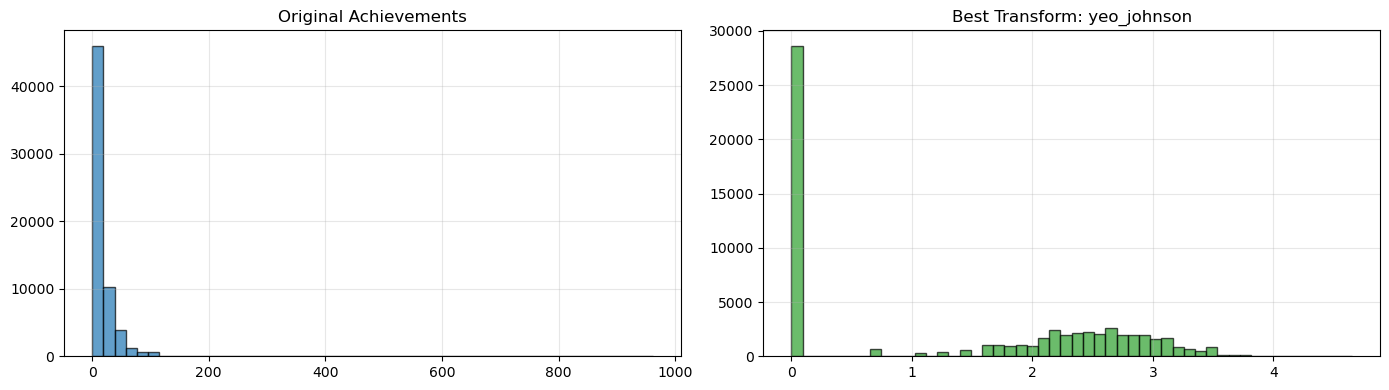

In [ ]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
import numpy as np
import matplotlib.pyplot as plt

ach = df['Achievements'].astype(float)
zero_pct = (ach == 0).mean()*100
skew_orig = skew(ach)

# 1) log1p
t_log = np.log1p(ach)
skew_log = skew(t_log)

# 2) sqrt
t_sqrt = np.sqrt(ach)
skew_sqrt = skew(t_sqrt)

# 3) Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson', standardize=False)
t_yj = pt.fit_transform(ach.to_frame())[:,0]
skew_yj = skew(t_yj)

# 4) Winsorization (üst %1) + log1p
upper_cap = ach.quantile(0.99)
ach_wins = ach.clip(upper=upper_cap)
t_wins_log = np.log1p(ach_wins)
skew_wins_log = skew(t_wins_log)

methods = {
    'original': (ach, skew_orig),
    'log1p': (t_log, skew_log),
    'sqrt': (t_sqrt, skew_sqrt),
    'yeo_johnson': (t_yj, skew_yj),
    'winsor_log1p': (t_wins_log, skew_wins_log)
}

# En düşük mutlak çarpıklık
best_name, (best_series, best_skew) = sorted(methods.items(), key=lambda kv: abs(kv[1][1]))[0]
df['achievements_best'] = best_series
df['achievements_has'] = (df['Achievements'] > 0).astype(int)
print(f"Sıfır oranı: {zero_pct:.2f}%")
print("Çarpıklıklar:")
for name,(ser, sk) in methods.items():
    print(f"  {name:12s}: {sk:6.3f}")
print(f"\nSeçilen yöntem: {best_name} (skew={best_skew:.3f})")

# Görsel karşılaştırma (orijinal vs seçilen)
fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].hist(ach, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Original Achievements')
axes[0].grid(alpha=0.3)
axes[1].hist(best_series, bins=50, edgecolor='black', alpha=0.7, color='tab:green')
axes[1].set_title(f'Best Transform: {best_name}')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Achievements metinsel dağılım özeti
series = df['Achievements'].dropna()

bins = 10  # gerekirse değiştirilebilir
counts, edges = np.histogram(series, bins=bins)
total = int(counts.sum())

print(f"Toplam oyun: {total}")
print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):
    left = int(edges[i])
    # Son aralığı sağ ucu kapsayacak şekilde yazalım
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    pct = (cnt/total)*100 if total > 0 else 0
    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")

Toplam oyun: 63221
Aralık -> Adet (Yüzde) | Çubuk
[0 - 95] ->  62083 ( 98.2%) █████████████████████████████████████████████████
[96 - 191] ->    939 (  1.5%) █
[192 - 287] ->     76 (  0.1%) █
[288 - 383] ->     49 (  0.1%) █
[384 - 479] ->     16 (  0.0%) █
[480 - 575] ->     25 (  0.0%) █
[576 - 671] ->     14 (  0.0%) █
[672 - 767] ->      8 (  0.0%) █
[768 - 863] ->      8 (  0.0%) █
[864 - 961] ->      3 (  0.0%) █


## Achievements Outlier Temizliği (Histogram Tabanlı)
Yukarıdaki 10 eşit aralıklı histogramda ilk aralık neredeyse tüm gözlemleri içeriyor. Bu nedenle eşik olarak ilk aralığın sağ sınırını kullanıp (edges[1]) bu değerin üzerindeki kayıtları outlier kabul ederek siliyoruz.


## Achievements'te Log Dönüşüm (Outlier Temizliğinden Sonra)
Amaç: Sağ kuyruğu kuvvetli olan Achievements dağılımını log1p ile daha dengeli hale getirmek ve aşırı büyük değerlerin etkisini azaltmak.

Adımlar:
- Outlier temizliği yapılmış güncel `Achievements` kolonu kullanılır.
- `log_achievements = log1p(Achievements)` hesaplanır.
- Öncesi / sonrası histogramları ve çarpıklık (skewness) karşılaştırılır.

Notlar:
- log1p(x) = ln(x + 1) formülü sıfır değerleri için tanımlıdır.
- Bu dönüşüm modellemeye yardımcı ek bir feature olarak saklanabilir; orijinal Achievements korunur.

In [ ]:
import numpy as np

# Negatif yorumların metinsel dağılım özeti
series = df['Negative'].dropna()

bins = 10  # gerekirse değiştirilebilir
counts, edges = np.histogram(series, bins=bins)
total = int(counts.sum())

print(f"Toplam oyun: {total}")
print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):
    left = int(edges[i])
    # Son aralığı sağ ucu kapsayacak şekilde yazalım
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    pct = (cnt/total)*100 if total > 0 else 0
    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")

Toplam oyun: 63221
Aralık -> Adet (Yüzde) | Çubuk
[0 - 89,596] ->  63209 (100.0%) █████████████████████████████████████████████████
[89,597 - 179,194] ->      8 (  0.0%) █
[179,195 - 268,792] ->      1 (  0.0%) █
[268,793 - 358,390] ->      1 (  0.0%) █
[358,391 - 447,988] ->      0 (  0.0%) 
[447,989 - 537,585] ->      0 (  0.0%) 
[537,586 - 627,183] ->      0 (  0.0%) 
[627,184 - 716,781] ->      0 (  0.0%) 
[716,782 - 806,379] ->      1 (  0.0%) █
[806,380 - 895,978] ->      1 (  0.0%) █


In [ ]:
import numpy as np



# Pozitif yorumların metinsel dağılım özeti

series = df['Positive'].dropna()

bins = 10  # gerekirse değiştirilebilir

counts, edges = np.histogram(series, bins=bins)

total = int(counts.sum())



print(f"Toplam oyun: {total}")

print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):

    left = int(edges[i])

    # Son aralığı sağ ucu kapsayacak şekilde yazalım

    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1

    pct = (cnt/total)*100 if total > 0 else 0

    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""

    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")


Toplam oyun: 63221
Aralık -> Adet (Yüzde) | Çubuk
[0 - 576,441] ->  63209 (100.0%) █████████████████████████████████████████████████
[576,442 - 1,152,883] ->      8 (  0.0%) █
[1,152,884 - 1,729,325] ->      3 (  0.0%) █
[1,729,326 - 2,305,767] ->      0 (  0.0%) 
[2,305,768 - 2,882,209] ->      0 (  0.0%) 
[2,882,210 - 3,458,651] ->      0 (  0.0%) 
[3,458,652 - 4,035,093] ->      0 (  0.0%) 
[4,035,094 - 4,611,535] ->      0 (  0.0%) 
[4,611,536 - 5,187,977] ->      0 (  0.0%) 
[5,187,978 - 5,764,420] ->      1 (  0.0%) █


## Pozitif Yorum Dağılımı (Metin Özeti)



Pozitif yorum sayılarının dağılımını grafik yerine metin olarak özetliyoruz. Aşağıda 10 eşit aralıklı bölmede (bin) her aralıkta kaç oyun olduğu ve yüzde karşılıkları yer alır. Gerekirse bin sayısı değiştirilebilir.


In [ ]:
# Outlier temizliği: log-IQR yöntemi

pos = df['Positive'].dropna()

log_pos = np.log1p(pos)

q1, q3 = log_pos.quantile([0.25, 0.75])

iqr = q3 - q1

upper_log = q3 + 1.5 * iqr

upper = np.expm1(upper_log)



before = len(df)

df = df[df['Positive'] <= upper].copy()

removed = before - len(df)



print(f"Outlier üst sınırı (Positive): {int(upper):,}")

print(f"Kaldırılan satır: {removed:,} / Yeni satır sayısı: {len(df):,}")


Outlier üst sınırı (Positive): 6,872
Kaldırılan satır: 1,388 / Yeni satır sayısı: 61,833


## Pozitif Yorum Outlier Temizliği



Pozitif yorum sayılarındaki uç değerleri (outlier) temizlemek için log-dönüşüm (log1p) üzerinde IQR yöntemini kullanıyoruz:



- Log1p(Positive) için Q1 ve Q3 hesaplanır.

- Üst sınır = Q3 + 1.5 × IQR olarak belirlenir ve orijinal ölçeğe expm1 ile geri dönülür.

- Positive bu sınırın üzerindeyse satır çıkarılır.



Bu yaklaşım ağır kuyruklu dağılımlarda aşırı yüksek değerlerin etkisini azaltır ve veri bütünlüğünü korur.


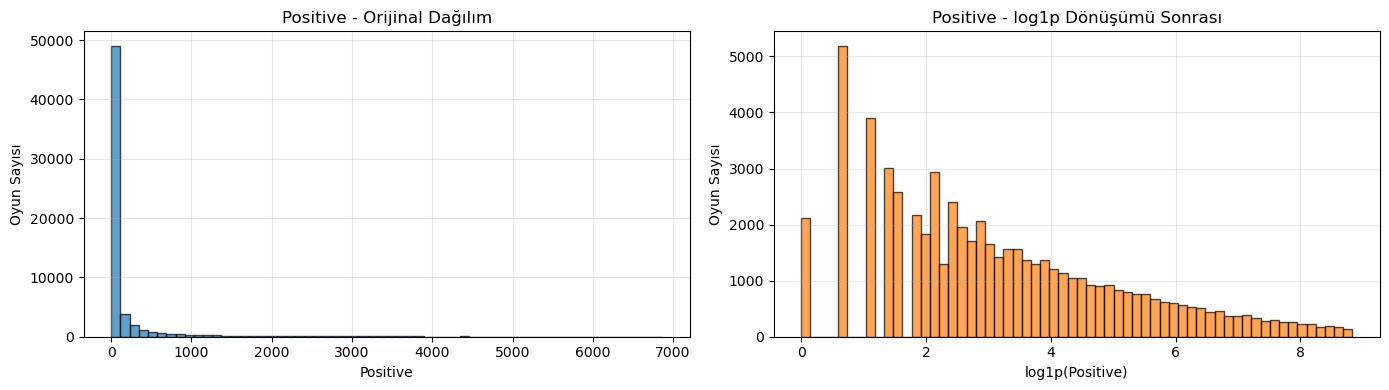

Çarpıklık (skewness):
  Orijinal: 5.57
  log1p    : 0.67
  Orijinal: 5.57
  log1p    : 0.67


In [ ]:
# Positive log transform before/after comparison

from scipy.stats import skew



orig = df['Positive']

log_pos = np.log1p(orig)

df['log_positive'] = log_pos  # İstersek modelde kullanılabilir



fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(orig, bins=60, edgecolor='black', alpha=0.7)

axes[0].set_title('Positive - Orijinal Dağılım')

axes[0].set_xlabel('Positive')

axes[0].set_ylabel('Oyun Sayısı')

axes[0].grid(alpha=0.3)



axes[1].hist(log_pos, bins=60, edgecolor='black', alpha=0.7, color='tab:orange')

axes[1].set_title('Positive - log1p Dönüşümü Sonrası')

axes[1].set_xlabel('log1p(Positive)')

axes[1].set_ylabel('Oyun Sayısı')

axes[1].grid(alpha=0.3)



plt.tight_layout()

plt.show()



print('Çarpıklık (skewness):')

print(f'  Orijinal: {skew(orig):.2f}')

print(f'  log1p    : {skew(log_pos):.2f}')


In [ ]:
# Outlier temizliği: Negative için log-IQR

neg = df['Negative'].dropna()

log_neg = np.log1p(neg)

q1, q3 = log_neg.quantile([0.25, 0.75])

iqr = q3 - q1

upper_log = q3 + 1.5 * iqr

upper = np.expm1(upper_log)



before = len(df)

df = df[df['Negative'] <= upper].copy()

removed = before - len(df)



print(f"Outlier üst sınırı (Negative): {int(upper):,}")

print(f"Kaldırılan satır: {removed:,} / Yeni satır sayısı: {len(df):,}")


Outlier üst sınırı (Negative): 996
Kaldırılan satır: 518 / Yeni satır sayısı: 61,315

Kaldırılan satır: 518 / Yeni satır sayısı: 61,315


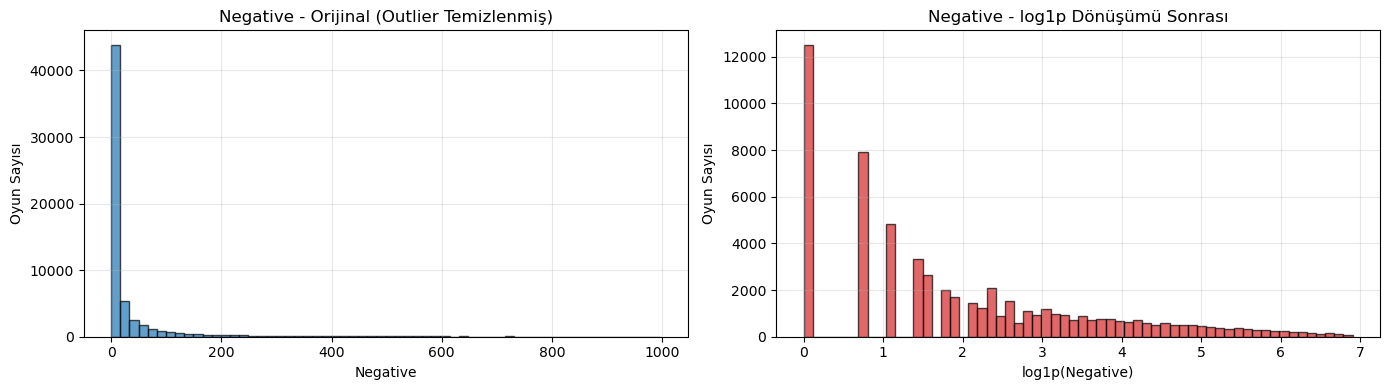

Çarpıklık (skewness):
  Orijinal (temizlenmiş): 4.88
  log1p               : 0.70


In [ ]:
# Negative log transform after outlier cleaning

from scipy.stats import skew

orig_neg = df['Negative']

log_neg = np.log1p(orig_neg)

df['log_negative'] = log_neg



fig, axes = plt.subplots(1, 2, figsize=(14,4))

axes[0].hist(orig_neg, bins=60, edgecolor='black', alpha=0.7)

axes[0].set_title('Negative - Orijinal (Outlier Temizlenmiş)')

axes[0].set_xlabel('Negative')

axes[0].set_ylabel('Oyun Sayısı')

axes[0].grid(alpha=0.3)



axes[1].hist(log_neg, bins=60, edgecolor='black', alpha=0.7, color='tab:red')

axes[1].set_title('Negative - log1p Dönüşümü Sonrası')

axes[1].set_xlabel('log1p(Negative)')

axes[1].set_ylabel('Oyun Sayısı')

axes[1].grid(alpha=0.3)



plt.tight_layout()

plt.show()



print('Çarpıklık (skewness):')

print(f'  Orijinal (temizlenmiş): {skew(orig_neg):.2f}')

print(f'  log1p               : {skew(log_neg):.2f}')


## Negatif Yorumlarda Log Dönüşüm (Outlier Temizliğinden Sonra)



Amaç: Outlier temizliği sonrası Negative dağılımını log1p ile daha simetrik hale getirmek ve görsel/istatistiksel olarak öncesi-sonrası farkını göstermek.


## Negatif Yorum Outlier Temizliği



Negatif yorumlarda log1p üzerinde IQR yöntemini kullanarak üst uç değerleri temizliyoruz:

- Q1, Q3 ve IQR (Q3 - Q1) hesaplanır.

- Üst sınır: Q3 + 1.5 × IQR; orijinal ölçeğe expm1 ile dönülür.

- Negative bu değerin üzerindeyse satır çıkarılır.


In [ ]:
# Negatif yorumların metinsel dağılım özeti

series = df['Negative'].dropna()

bins = 10

counts, edges = np.histogram(series, bins=bins)

total = int(counts.sum())



print(f"Toplam oyun: {total}")

print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):

    left = int(edges[i])

    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1

    pct = (cnt/total)*100 if total > 0 else 0

    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""

    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")


Toplam oyun: 61315
Aralık -> Adet (Yüzde) | Çubuk
[0 - 98] ->  55479 ( 90.5%) █████████████████████████████████████████████
[99 - 198] ->   2741 (  4.5%) ██
[199 - 297] ->   1138 (  1.9%) █
[298 - 397] ->    676 (  1.1%) █
[398 - 497] ->    432 (  0.7%) █
[498 - 596] ->    292 (  0.5%) █
[597 - 696] ->    190 (  0.3%) █
[697 - 795] ->    171 (  0.3%) █
[796 - 895] ->    120 (  0.2%) █
[896 - 996] ->     76 (  0.1%) █


## Negatif Yorum Dağılımı (Metin Özeti)



Negatif yorum sayılarının dağılımını grafik yerine metin olarak özetliyoruz. Aşağıda 10 eşit aralıklı bölmede her aralıkta kaç oyun olduğu ve yüzdeleri yer alır.


## Pozitif Yorumlarda Log Dönüşüm (Öncesi/Sonrası)



Amaç: Sağ kuyruğu baskın olan Positive dağılımını log1p ile daha simetrik hale getirmek ve modellemeye uygun bir ölçeğe taşımak.



- Dönüşüm: log1p(x) = ln(x + 1)

- Beklenti: Çarpıklığın (skewness) azalması, histogramda daha dengeli bir dağılım

- Not: Dönüşüm yalnızca görselleştirme ve bazı modeller için; temel metrik olarak yine orijinal Positive saklıdır.


## 2. Feature Engineering

Popülarite skorunu hesaplamak için gerekli özellikleri hazırlayalım.

**4 özellik hazırlanacak:**
- Sahip sayısı (normalize)
- Oynanma süresi (normalize)
- Yorum sayısı (log + normalize)
- Yorum kalitesi (pozitif oran)

In [ ]:
# Review count
df['review_count'] = df['Positive'] + df['Negative']

# Normalizasyon
scaler = MinMaxScaler()
df['norm_owners'] = scaler.fit_transform(df[['Estimated owners numeric']])
df['norm_playtime'] = scaler.fit_transform(df[['Average playtime forever']])

# Log transformation sonrası normalize
df['log_reviews'] = np.log1p(df['review_count'])
df['norm_reviews'] = scaler.fit_transform(df[['log_reviews']])

# Review quality (pozitif oran)
df['review_quality'] = df['Positive'] / df['review_count']


## 3. Popülarite Skoru

Ağırlıklı skoru hesaplayalım:
-  30% Sahip sayısı
-  30% Yorum sayısı  
-  25% Oynanma süresi
-  15% Yorum kalitesi

In [ ]:
df['popularity_score'] = (
    0.30 * df['norm_owners'] +
    0.30 * df['norm_reviews'] +
    0.25 * df['norm_playtime'] +
    0.15 * df['review_quality']
)

print(f" Popülarite skoru hesaplandı")
print(f"\n İstatistikler:")
print(f"   Min:      {df['popularity_score'].min():.4f}")
print(f"   Maks:     {df['popularity_score'].max():.4f}")
print(f"   Ortalama: {df['popularity_score'].mean():.4f}")
print(f"   Medyan:   {df['popularity_score'].median():.4f}")

 Popülarite skoru hesaplandı

 İstatistikler:
   Min:      0.0000
   Maks:     0.6313
   Ortalama: 0.2109
   Medyan:   0.2047


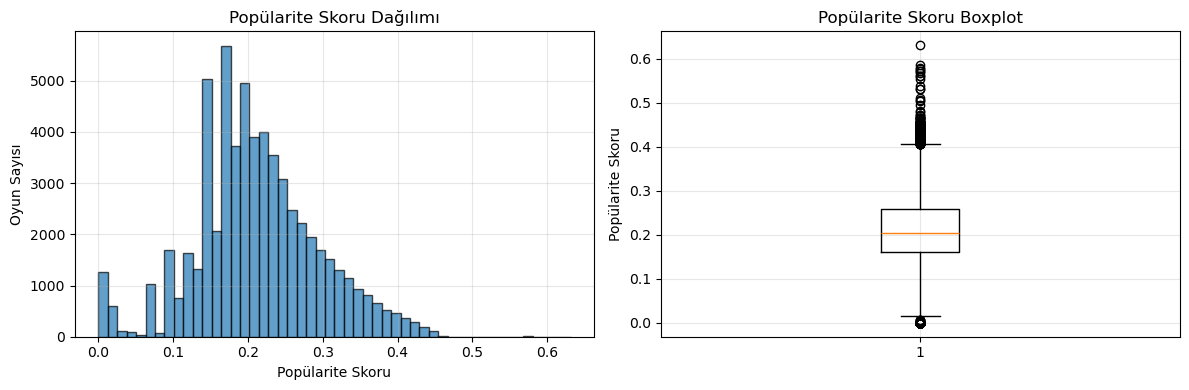

In [ ]:
# Görselleştirme
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['popularity_score'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Popülarite Skoru')
plt.ylabel('Oyun Sayısı')
plt.title('Popülarite Skoru Dağılımı')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['popularity_score'], vert=True)
plt.ylabel('Popülarite Skoru')
plt.title('Popülarite Skoru Boxplot')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Target Kategorileri

Skoru 3 kategoriye bölelim: Low, Medium, High

In [ ]:
# Quantile-based kategoriler (her biri %33)
low_threshold = df['popularity_score'].quantile(0.33)
high_threshold = df['popularity_score'].quantile(0.67)

df['target'] = pd.cut(
    df['popularity_score'],
    bins=[-np.inf, low_threshold, high_threshold, np.inf],
    labels=['Low', 'Medium', 'High']
)

# Encoding
df['target_encoded'] = df['target'].map({'Low': 0, 'Medium': 1, 'High': 2})

print(f"\n Dağılım:")
target_dist = df['target'].value_counts().sort_index()
for cat, count in target_dist.items():
    pct = count/len(df)*100
    bar = "█" * int(pct/2)
    print(f"   {cat:8} {count:6,} ({pct:5.1f}%) {bar}")


 Dağılım:
   Low      21,113 ( 34.4%) █████████████████
   Medium   19,977 ( 32.6%) ████████████████
   High     20,225 ( 33.0%) ████████████████


/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_3917/1732028637.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df[df['target']==cat]['Estimated owners numeric'] for cat in ['Low', 'Medium', 'High']],
/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_3917/1732028637.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([df[df['target']==cat]['review_count'] for cat in ['Low', 'Medium', 'High']],
/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_3917/1732028637.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df[df['target']=

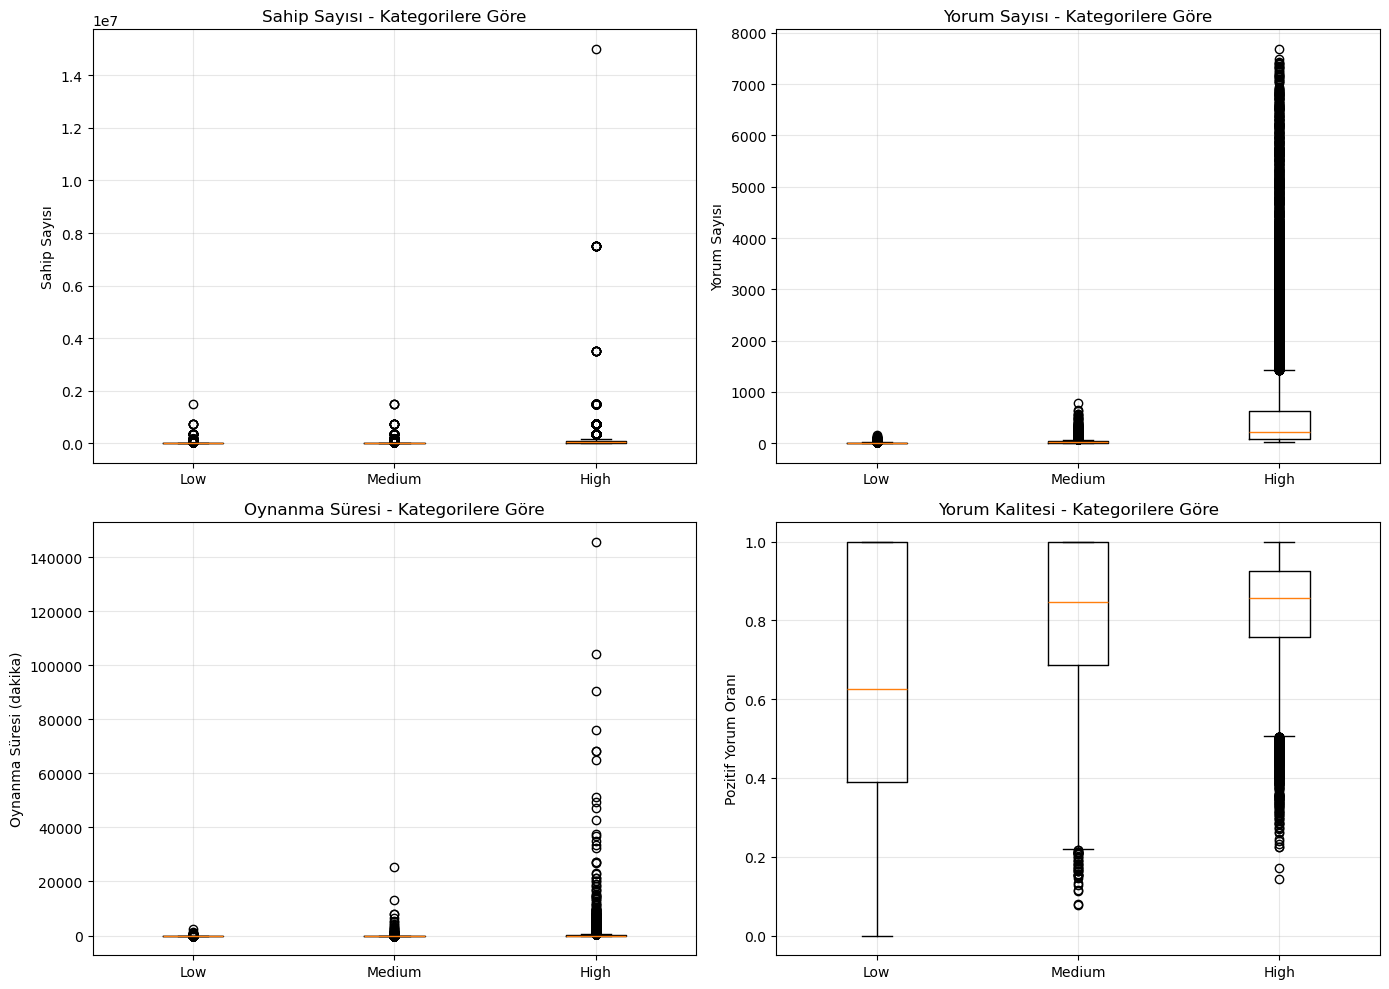

In [ ]:
# Her kategorinin özelliklerini karşılaştır
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sahip sayısı
axes[0, 0].boxplot([df[df['target']==cat]['Estimated owners numeric'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[0, 0].set_ylabel('Sahip Sayısı')
axes[0, 0].set_title('Sahip Sayısı - Kategorilere Göre')
axes[0, 0].grid(alpha=0.3)

# Yorum sayısı
axes[0, 1].boxplot([df[df['target']==cat]['review_count'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[0, 1].set_ylabel('Yorum Sayısı')
axes[0, 1].set_title('Yorum Sayısı - Kategorilere Göre')
axes[0, 1].grid(alpha=0.3)

# Oynanma süresi
axes[1, 0].boxplot([df[df['target']==cat]['Average playtime forever'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[1, 0].set_ylabel('Oynanma Süresi (dakika)')
axes[1, 0].set_title('Oynanma Süresi - Kategorilere Göre')
axes[1, 0].grid(alpha=0.3)

# Review quality
axes[1, 1].boxplot([df[df['target']==cat]['review_quality'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[1, 1].set_ylabel('Pozitif Yorum Oranı')
axes[1, 1].set_title('Yorum Kalitesi - Kategorilere Göre')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Temizlik ve Kaydetme

Geçici sütunları kaldırıp veriyi kaydedelim.

In [ ]:
# Geçici sütunları kaldır
temp_cols = ['log_reviews', 'norm_owners', 'norm_reviews', 'norm_playtime', 'review_quality']
df = df.drop(columns=temp_cols)

# Kaydet
df.to_parquet('data_with_target.parquet', index=False)